In [1]:
!pip install transformers
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


сначала проверим бэйзлайн до дообучения:

In [46]:
from transformers import pipeline

In [47]:
gen = pipeline("text-generation")
gen("I feel so bad about my relationships. Therapist: ")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'I feel so bad about my relationships. Therapist: \xa0I know. Your doctor has been very supportive. Psychologist: \xa0What about therapy that seems to make you more anxious, and makes you less self-aware over time?\n'}]

In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelWithLMHead
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam
import torch
import tqdm

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
data = pd.read_csv('gdrive/My Drive/data_history_prepared.csv')
data = data.drop(columns=['Unnamed: 0'])

In [8]:
data.shape

(1457023, 2)

# Обработаем датасет.

In [9]:
#Далее в модели используется обрезание датасета по max_token_length, Однако там обрезается на полуслове, чтоб этого избежать, зададим значение max_token_length
# и далее будем заранее все объекты данных обрезать по законченным фразам, но чтоб они были не больше чем max_token_length

def split_no_more_than_max_tokens(text,tokenizer,max_token_length):
  max_ind = len(list(filter(lambda x: x<max_token_length, np.cumsum(list(map(lambda x: len(tokenizer(x)['input_ids']),text.split(tokenizer.eos_token)))))))
  text = tokenizer.eos_token.join(text.split(tokenizer.eos_token)[:max_ind])
  return text 

class ChatData(Dataset):
    def __init__(self, data, tokenizer,size=5000,max_token_length=350,mode='new'):
        self.data = data
        self.X = []
        self.y = []
        self.examples=[]
        for i,row in self.data.iterrows():
          text = row['index']+row['0'] #строчка данных - это весь диалог с разелителями Patient, Therapist 
          if mode == 'new': #Здесь проводились эксперименты по специальным токенам и в ходе экспериментов победил вариант с [Therapist], но это субъективно
            text = text[10:].replace('Therapist:','[Therapist]').replace('Patient:',tokenizer.eos_token) #Заменяю Therapist на  [Therapist], чтоб был отдельный токен и не путал со словом "терапевт"
          else:
            text = text[10:].replace('Therapist:',tokenizer.eos_token).replace('Patient:',tokenizer.eos_token) #пациента заменяем на токен EOS, просто потому что по сути Patient должен отвечать сразу после ответа терапевта-бота, 
            #то есть пациент - это конец ответа бота. 
              

          text = split_no_more_than_max_tokens(text,tokenizer,max_token_length-1)
          self.examples.append(text+ tokenizer.eos_token)
            
        print(self.examples[1])
        
        self.X_encoded = tokenizer(self.examples,  max_length=max_token_length, truncation=True, padding="max_length", return_tensors="pt")

        self.input_ids = self.X_encoded['input_ids']
        self.attentions_mask= self.X_encoded['attention_mask']
        print(self.attentions_mask)


    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return self.input_ids[item], self.attentions_mask[item]

Мой датасет состоит ведь из цепочек диалогов инкрементирующихся по одной фразе, подходящий для обучения gpt2. 
 </br>
В туториале по DialoGPT, датасет был представлен так, что один диалог = один объект данных, поэтому я фильтрую свой датасет, оставляя только полноценные диалоги(=самые длинные цепочки):

In [10]:

filtered_ind = []
val_pred = 1000
val_next = 1

for i in range(len(data)):
  if len(data['index'].iloc[i])> val_pred and len(data['index'].iloc[i])>val_next:
    filtered_ind.append(i)
  val_pred = len(data['index'].iloc[i])
  try: val_next=len(data['index'].iloc[i+2]) 
  except: break
filtered_data = data.iloc[filtered_ind]
data=filtered_data

In [11]:
train_data, test_data = data.iloc[:5000], data.iloc[5000:6250]
train_data = train_data[['index','0']]
test_data = test_data[['index','0']]

подсчитаем статистику, чтоб оценить max_token_length

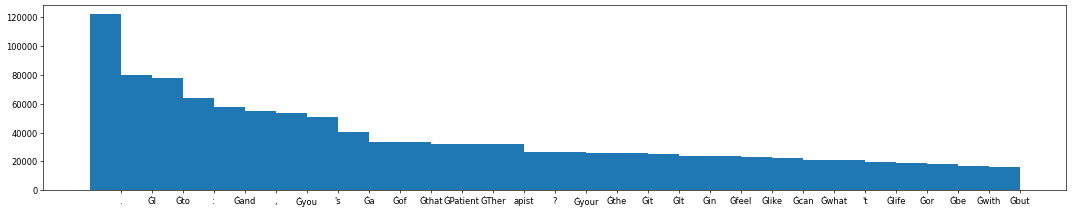

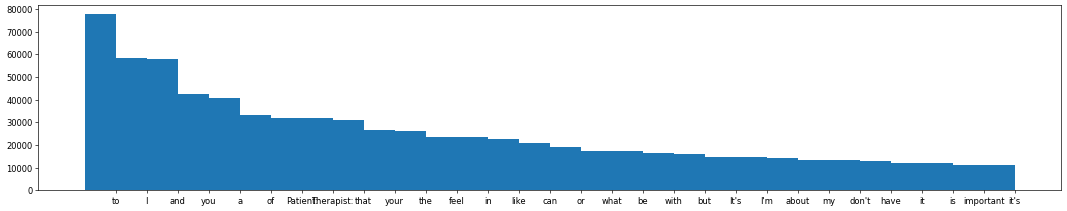

Mean: 466.1406, Median: 454.0, Standard Deviation: 94.75107615030026, 90th Percentile: 795.0


(array([   9.,  339.,  717., 1292., 1382.,  672.,  201.,  184.,   78.,
         126.]),
 array([225., 282., 339., 396., 453., 510., 567., 624., 681., 738., 795.]),
 <BarContainer object of 10 artists>)

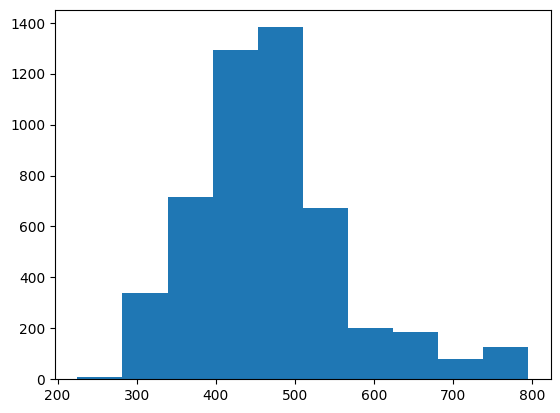

In [12]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())
    
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small', cache_dir='cached')
lens, tok_cnt, word_cnt = get_counter_and_lens(train_data[train_data.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

print(f'Mean: {np.mean(lens)}, Median: {np.median(lens)}, Standard Deviation: {np.std(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plt.hist(lens)

In [13]:
#Наверное 450-500 было бы логичнее, но не влазим по памяти, поэтому 300 как некоторый трейдофф
max_token_length = 300
mode='new'

In [14]:
import torch
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [15]:
device

'cuda'

In [16]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
if mode == 'new':
  tokenizer.add_special_tokens({'additional_special_tokens': ['[Therapist]']})

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})


model = AutoModelWithLMHead.from_pretrained('microsoft/DialoGPT-small') 
model.resize_token_embeddings(len(tokenizer))

chatData_train = ChatData(train_data,tokenizer=tokenizer)
chatDatatrain =  DataLoader(chatData_train, batch_size=16)

chatData_test = ChatData(test_data,tokenizer=tokenizer)
chatDatatest =  DataLoader(chatData_test, batch_size=16)

model = model.to(device)
model.train()

optim = Adam(model.parameters(), lr=1e-3)


Using pad_token, but it is not set yet.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


I've been feeling really anxious lately, but I can't pinpoint exactly why. It's like this constant feeling of dread and worry that's always there, no matter what I do. [Therapist] That sounds really distressing. Have you noticed any particular triggers for these feelings, or do they seem to come out of nowhere? <|endoftext|> It feels like it's always there in the background, but it gets worse when I think about the future. It's like I'm afraid of what's to come but I'm not even sure what that is. [Therapist] It sounds like you might be experiencing some anxiety around the uncertainty of the future. That's a really common feeling, especially in times of change and transition. Have you done any thinking about what you'd like your future to look like, or what steps you could take to make that a reality? <|endoftext|> I have some ideas, but when I try to think about it too much it just makes me feel more anxious. Like what if I make the wrong choice or it doesn't work out? [Therapist] That

In [17]:
def train(chatData, model, optim,tokenizer,mode, epochs=12):    
    for i in tqdm.tqdm(range(epochs)):
        losses=[]
        for X,a in chatData:
            X = X.to(device)
            a=a.to(device)
            optim.zero_grad()
            loss = model(X,attention_mask=a, labels=X).loss
            loss.backward()
            optim.step()
            losses.append(loss)
        torch.save(model.state_dict(), "model_state.pt") 
        print(infer("I feel so bad about my relationships.", model,tokenizer,mode))
        print('loss', np.mean(list(map(lambda x: x.cpu().detach().numpy(),losses))))


def infer(inp,model,tokenizer,mode):
    if mode == 'new':
      inp = inp + '[Therapist]' #надо добавить токен чтоб генератор понимал что он должен отвечать как терапевт
    else:
      inp = inp + tokenizer.eos_token
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device) 
    output = model.generate(X, max_length=50)
    output = tokenizer.decode(output[0])
    return output


In [18]:
train(chatDatatrain, model, optim, tokenizer, mode, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 20%|██        | 1/5 [08:32<34:10, 512.54s/it]

I feel so bad about my relationships.[Therapist] It's understandable to feel that way sometimes. Have you don't have any real direction. <|endoftext|>
loss 2.1316206


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 40%|████      | 2/5 [16:55<25:21, 507.05s/it]

I feel so bad about my relationships.[Therapist] It's understandable to feel that way sometimes. Our culture puts so much emphasis on finding our purpose or calling, and it can be overwhelming. Have you explored any hobbies or interests that bring you joy? 
loss 0.08035211


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 60%|██████    | 3/5 [25:18<16:50, 505.12s/it]

I feel so bad about my relationships.[Therapist] It's understandable to feel that way sometimes. Have you explored any potential interests or passions? <|endoftext|>
loss 0.034678616


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 80%|████████  | 4/5 [33:41<08:24, 504.15s/it]

I feel so bad about my relationships.[Therapist] It's understandable to feel that way at times. Can you tell me more about what's causing you to feel this way? <|endoftext|>
loss 0.023178967


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
100%|██████████| 5/5 [42:07<00:00, 505.53s/it]

I feel so bad about my relationships.[Therapist] It's understandable to feel that way sometimes. Have you explored any potential interests or passions? What gives you a sense of fulfillment or joy? <|endoftext|>
loss 0.022362549


![image.png](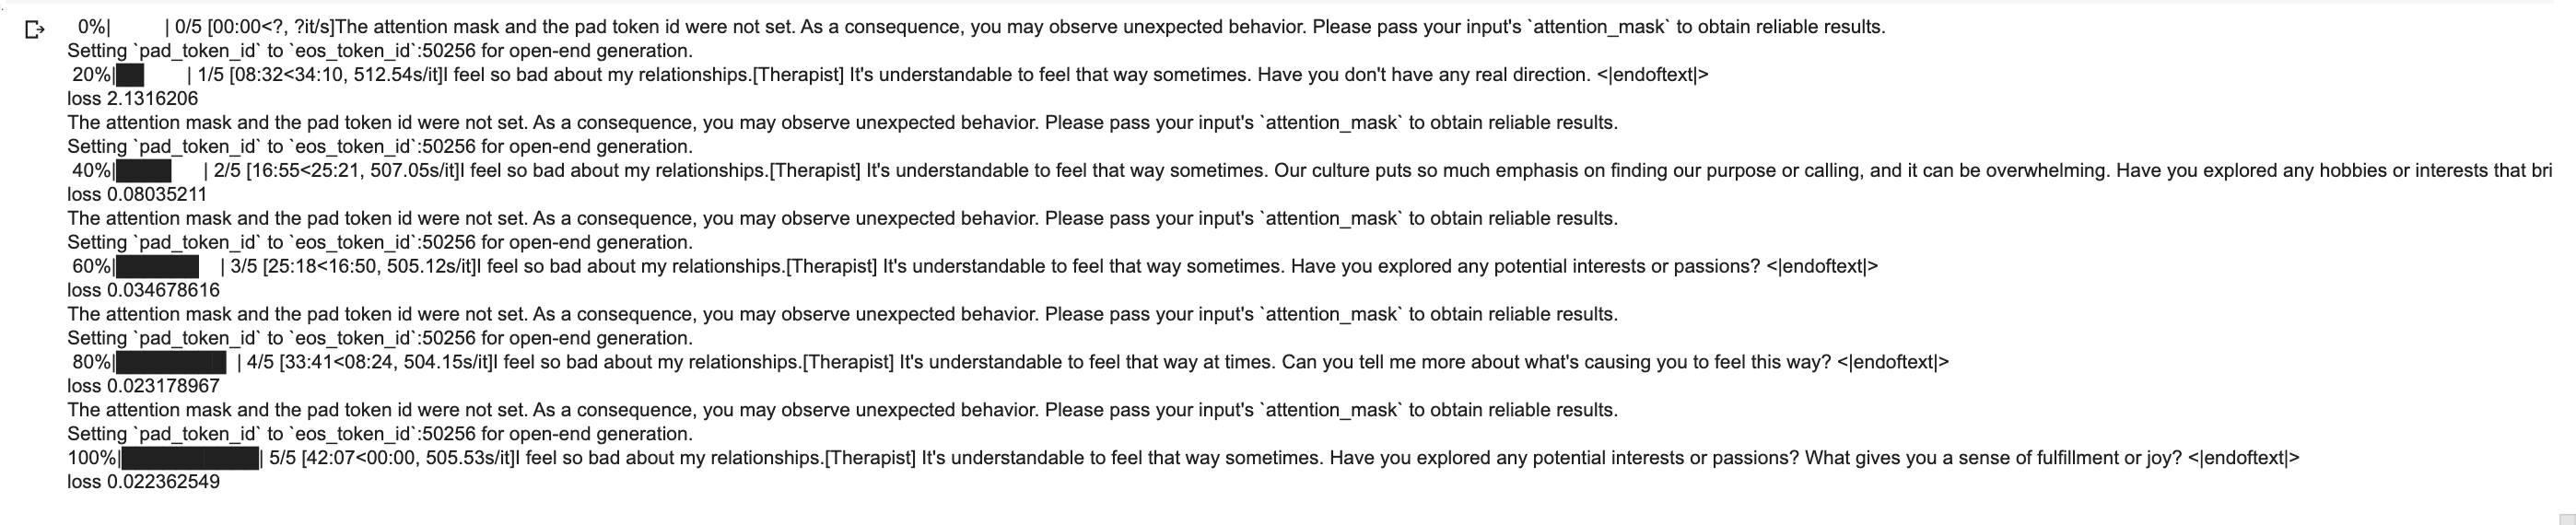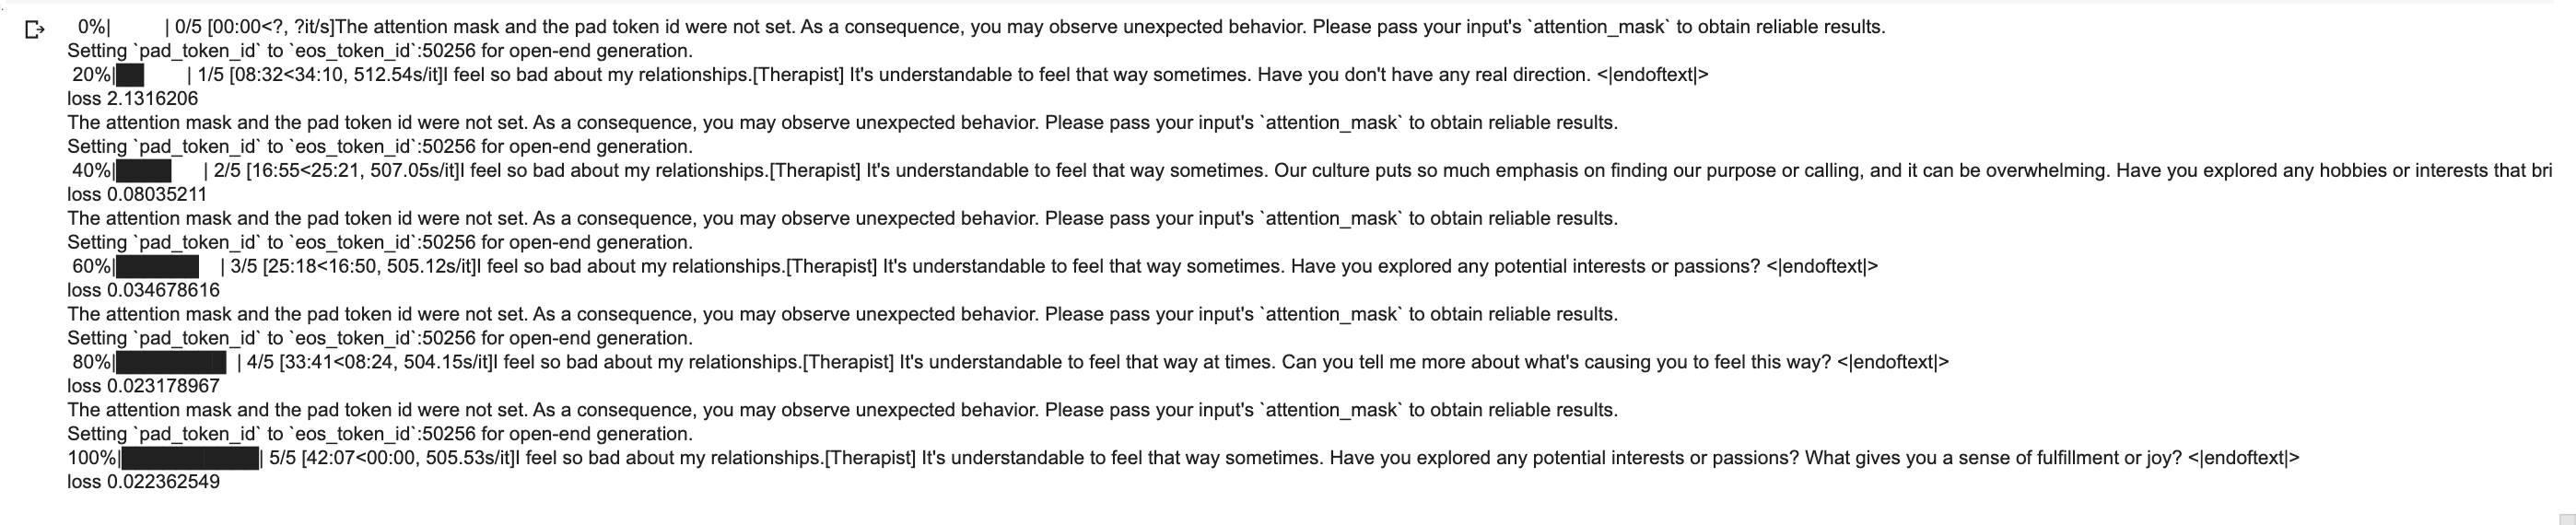)

In [19]:
infer('I feel so bad about my relationships.',  model,tokenizer,mode)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"I feel so bad about my relationships.[Therapist] It's understandable to feel lost or uncertain about the direction of your life. Can you tell me more about what's been going on for you lately? <|endoftext|>"

In [44]:
#симулируем диалог
def split_no_more_than_min_tokens(text,tokenizer,max_token_length): #обрезаем с конца, история будет забываться, но по типу очереди - первый пришел - первый и забылся
  split=text.split(tokenizer.eos_token)
  min_ind=len(list(filter(lambda x: x<max_token_length, np.cumsum(list(reversed(list(map(lambda x: len(tokenizer(x)['input_ids']),split))))))))
  return tokenizer.eos_token.join(split[len(split)-min_ind:])

inputtext=input()
inputtext+=' what you say about it?'+'[Therapist]'
print(inputtext)
bot_input_ids = tokenizer.encode(inputtext , return_tensors='pt').to(device)
chat_history_ids = model.generate(
        bot_input_ids, max_length=max_token_length,
        pad_token_id=tokenizer.eos_token_id,
        top_p=0.92, top_k = 50
    )

output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=False)
if '[Therapist]' in output:
  output = output.split('[Therapist]')[-1]
print('Therapist: {}'.format(output))

while True:
    inputtext += output + tokenizer.eos_token + input() + ' what you say about it?'+'[Therapist]' # немного промпт-инжиринга; в целом, в большинстве случаев генерирует нормально, но изредка все-таки пытается дополнить фразу пациента
    inputtext = split_no_more_than_min_tokens(inputtext, tokenizer, max_token_length)
    bot_input_ids =  tokenizer.encode(inputtext, return_tensors='pt').to(device)
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=max_token_length,
        pad_token_id=tokenizer.eos_token_id,
        top_p=0.92, top_k = 50
    )
    output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=False)
    if '[Therapist]' in output:
      output = output.split('[Therapist]')[-1] #к сожалению не очень хорошо обучилось и периодически он 
      #хочет продолжить фразу за мной, потом сам добавляем токен Терапист и отвечает уже как надо, для таких случаев небольшой хардкод | пост-процессинг, вывода языковой модели, для улучшения человеческого опыта.
    
    # pretty print last ouput tokens from bot
    print('Therapist: {}'.format(output))

i feel problems with my career and feel anxiety about it
i feel problems with my career and feel anxiety about it what you say about it?[Therapist]
Therapist:  It's understandable to feel that way at times. Let's explore what's been going on for you. What are your current goals or aspirations? <|endoftext|>
My current goal is my career
Therapist:  It's important to remember that the fear of failure is a natural part of growth and learning. Have you considered exploring your values and priorities? What would it be? <|endoftext|>
i do not know, may be my values are my family and successes in career
Therapist:  It's important to recognize that taking risks and making mistakes is a natural part of the learning process. Have you considered exploring your interests or hobbies? <|endoftext|>
yes i have hobbies, I love painting and dancing
Therapist:  It's important to remember that making mistakes is a part of the learning process, but it's also important to remember that taking risks and mak

KeyboardInterrupt: ignored

In [45]:
#где то на просторах hugging face  я нашла что перплексию можно посчитать так
nlls=[]
for X,a in chatDatatest:
      with torch.no_grad():
            X = X.to(device)
            nll = model(X,labels=X).loss
            nlls.append(nll)
print(torch.exp(torch.stack(nlls).mean()))
#вполне хороший результат

tensor(1.4235, device='cuda:0')


# Выводы
* довольно быстро дообучилось, удивительно (2 эпохи и лосс уже почти 0)
* ответы слишком однообразны, я думаю что сами данные слишком однообразны  и надо с ними поработать
* так же планирую позже обучать на всех данных а не только на срезе 5к

In [ ]:
#в целом неплохо